In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# %matplotlib widget

from typing import Optional

from pileup_ml.detectors.pixels import RowColMapping, PixelDetector, PixelModule
from pileup_ml.events import PixelDigiEvent, PixelModuleHitCluster
from pileup_ml.plots import plot_pixel_module
from pileup_ml.visualization.pixels import visualize_event

# Pixel digis

In [2]:
pixel_modules = PixelModule.read_json('../data/detid_info/detids_bpix.json', '../data/detid_info/detids_fpix.json')
rowcol_mapping = RowColMapping.read_csv('../data/detid_info/rowcol_to_local.csv')
pix_det = PixelDetector(pixel_modules, rowcol_mapping)
pixel_digi_events = PixelDigiEvent.read_root('../data/root/pixel_digis_10.root', pix_det)

100%|██████████| 10/10 [00:00<00:00, 251.83it/s]


In [3]:
visualize_event(pixel_digi_events[0])

FEngine (64 bits) created at 0x3104f0000 (threading is enabled)
FEngine resolved backend: OpenGL


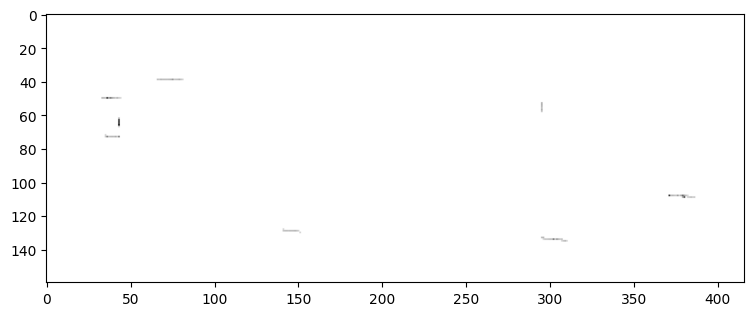

In [4]:
plt.figure(figsize=(9, 4))
plot_pixel_module(pixel_digi_events[0], pixel_modules[0])

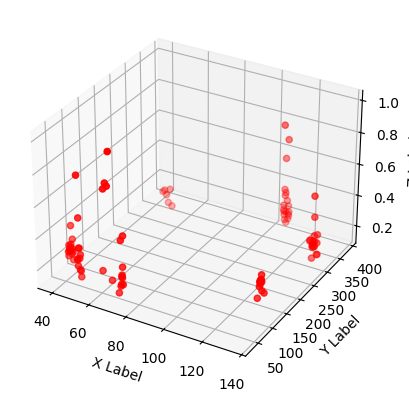

In [5]:
img = pixel_digi_events[0].hits[0].to_image()
x, y = np.where(img > 0)
z = img[x, y]

# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [5]:
MODULE_ROWS = 160
MODULE_COLS = 416
MODULE_PIXELS = MODULE_ROWS * MODULE_COLS
print(MODULE_PIXELS)

66560


In [5]:
n_modules = len([m for m in pix_det.modules])

# Hits per event/det_id
rows = []
for event in pixel_digi_events:
    for h in event.hits:
        rows.append({
            'event': event.id_,
            'det_id': h.module.det_id,
            # 'det_id': det_id,
            'n_hits': len(h),
            # 'n_hits': len(event.det_id_hits[det_id]['adc']),
        })
df_events = pd.DataFrame.from_records(rows)

# Module properties
df_modules_bpix = pd.DataFrame.from_records([
    {key: dict(module)[key] for key in dict(module)
        if key in ['det_id', 'layer', 'ladder', 'module']}
    for module in pix_det.bpix_modules
])

df_modules_fpix = pd.DataFrame.from_records([
    {key: dict(module)[key] for key in dict(module)
        if key in ['det_id', 'disk', 'blade', 'panel', 'module', 'side']}
    for module in pix_det.fpix_modules
])

Text(0, 0.5, 'Event count')

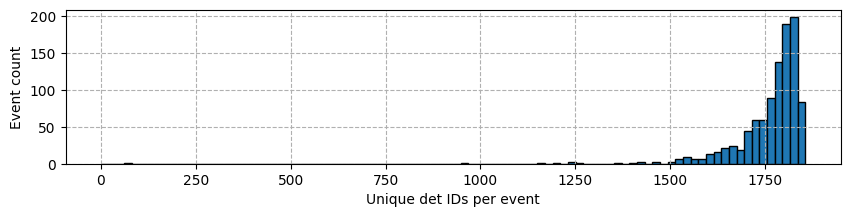

In [8]:
# Det IDs per event
plt.figure(figsize=(10, 2))
plt.hist(df_events.groupby('event').agg({'det_id': 'count'})['det_id'].to_numpy(),
         bins=n_modules // 20, range=(0, n_modules), edgecolor='black')
plt.grid(linestyle='--')
plt.xlabel('Unique det IDs per event')
plt.ylabel('Event count')

Text(0.5, 0, 'Hit percentage')

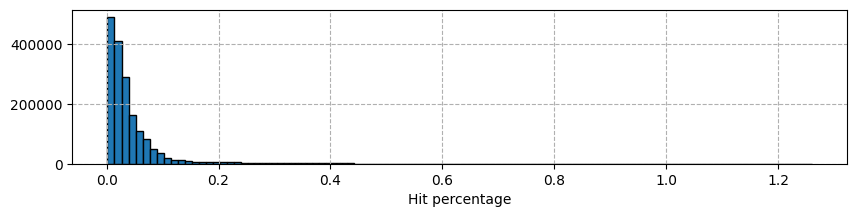

In [9]:
# Hit percentages per det ID
hit_pcts = df_events['n_hits'] / MODULE_PIXELS * 100
plt.figure(figsize=(10, 2))
plt.hist(hit_pcts, bins=100, edgecolor='black')
plt.grid(linestyle='--')
plt.xlabel('Hit percentage')

Text(0.5, 1.0, 'FPIX')

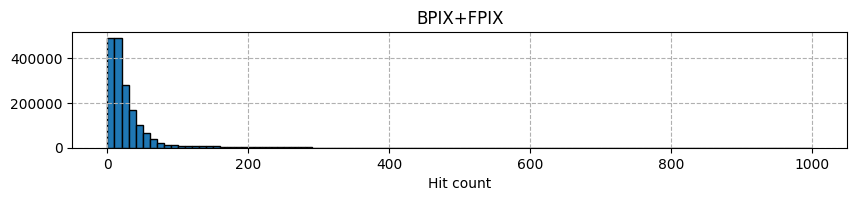

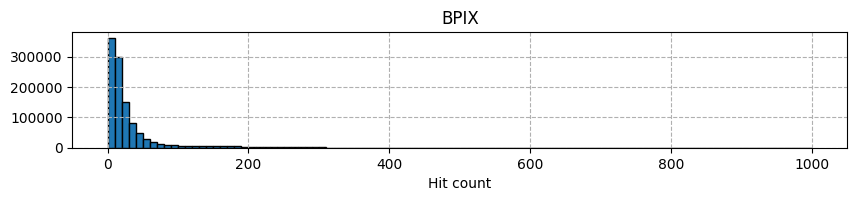

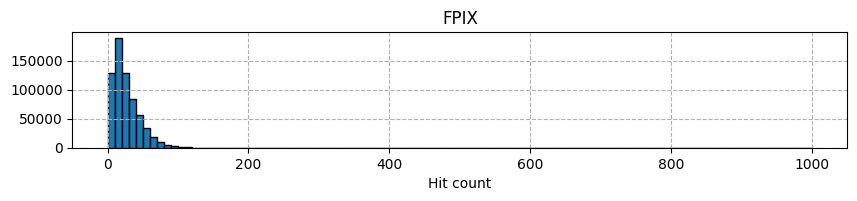

In [10]:
# Hit count per det ID
plt.figure(figsize=(10, 1.5))
plt.hist(df_events['n_hits'], bins=100, range=(0, 1000), edgecolor='black')
plt.grid(linestyle='--')
plt.xlabel('Hit count')
plt.title('BPIX+FPIX')

plt.figure(figsize=(10, 1.5))
plt.hist(df_events.merge(df_modules_bpix)['n_hits'], bins=100, range=(0, 1000), edgecolor='black')
plt.grid(linestyle='--')
plt.xlabel('Hit count')
plt.title('BPIX')

plt.figure(figsize=(10, 1.5))
plt.hist(df_events.merge(df_modules_fpix)['n_hits'], bins=100, range=(0, 1000), edgecolor='black')
plt.grid(linestyle='--')
plt.xlabel('Hit count')
plt.title('FPIX')

In [11]:
df_events[df_events['n_hits'] > 100]

,event,det_id,n_hits
15,84921001,303046688,130
24,84921001,303054852,155
25,84921001,303054856,163
35,84921001,303058960,123
39,84921001,303058976,119
...,...,...,...
1761229,84921999,305242120,122
1761345,84921999,305299488,117
1762220,84921999,352700420,173
1762269,84921999,352801796,108


# Hit clusters

In [7]:
clusters = [
    cluster
    for event in pixel_digi_events
    for module_hits in event.hits
    for cluster in module_hits.clusters()
]

n_clusters_per_image = [
    len(module_hits.clusters())
    for event in pixel_digi_events
    for module_hits in event.hits    
]

len(clusters)

104486

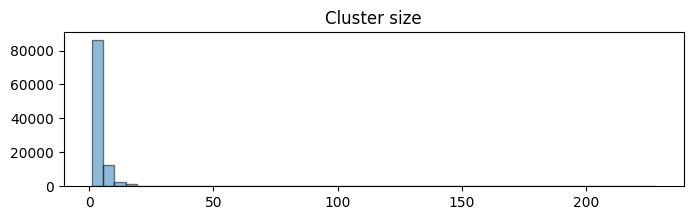

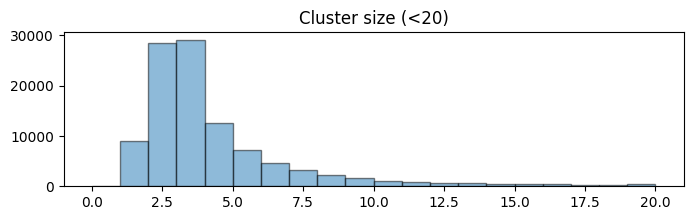

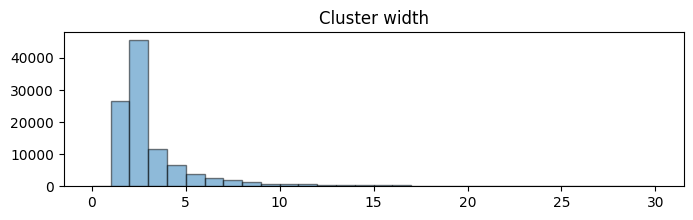

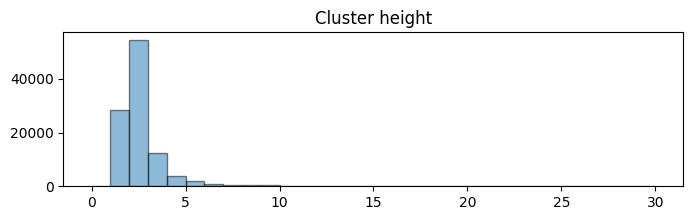

In [35]:
plt.figure(figsize=(8, 2))
plt.hist([len(cl) for cl in clusters], 
        #   range=(0, 20),
          bins=50, alpha=0.5, label='size', edgecolor='black')
plt.title('Cluster size')
plt.show()

plt.figure(figsize=(8, 2))
plt.hist([len(cl) for cl in clusters],
          range=(0, 20),
          bins=20, 
          alpha=0.5, label='size', edgecolor='black')
plt.title('Cluster size (<20)')
plt.show()

plt.figure(figsize=(8, 2))
plt.hist([cl.width for cl in clusters], bins=30, range=(0, 30), alpha=0.5, label='width', edgecolor='black')
plt.title('Cluster width')
plt.show()

plt.figure(figsize=(8, 2))
plt.hist([cl.height for cl in clusters], bins=30, range=(0, 30), alpha=0.5, label='height', edgecolor='black')
plt.title('Cluster height')
plt.show()

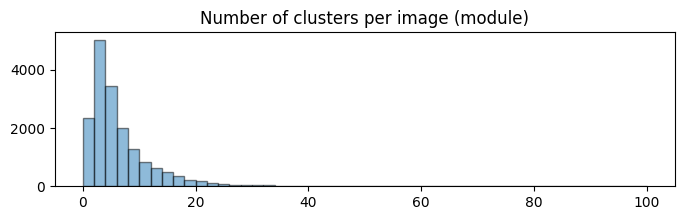

In [33]:
plt.figure(figsize=(8, 2))
plt.hist(n_clusters_per_image, 
         range=(0, 100),
         bins=50, alpha=0.5, label='size', edgecolor='black')
plt.title('Number of clusters per image (module)')
plt.show()

## Outliers

In [10]:
for event in pixel_digi_events:
    for module_hits in event.hits:
        for cluster in module_hits.clusters():
            if cluster.height > 100:
                err_event, err_module_hits, err_cluster = event, module_hits, cluster
                break

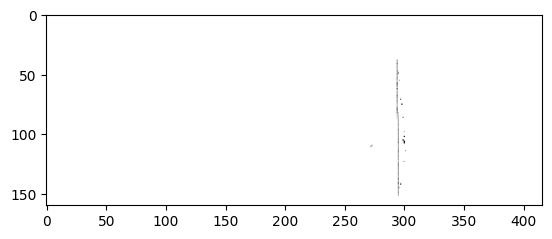

In [11]:
plt.figure()
plt.imshow(err_module_hits.to_image(), cmap='gist_yarg')
plt.show()